
<font face="黑体" color=deepskyblue size=12>Sydney Livability Analysis</font>

<!-- <table><tr><td bgcolor=azure>DATA2001_yellow</td></tr></table> -->


# Task 1

## 1: Import module

In [70]:
# initial
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import statistics
import seaborn as sns

import geoplot as gplt
from shapely import wkt
import matplotlib as mpl
import json
import os

## 2: Connect to database

In [71]:
credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        try:
            db = create_engine('postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db, echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn
    
def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(sqlcmd, args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

In [72]:
db, conn = pgconnect(credentials)

Connected successfully.


## 3: data Integrates

In [87]:
## Read dataset file
data_business = pd.read_csv('BusinessStats.csv')

data_neighb = pd.read_csv('Neighbourhoods.csv', index_col=[0]) #not include the index column

data_school_1 = gpd.read_file("school_catchments/catchments_primary.shp")
data_school_2 = gpd.read_file("school_catchments/catchments_secondary.shp")
data_school_3 = gpd.read_file("school_catchments/catchments_future.shp")

data_break_enter = gpd.read_file("break_and_enter/BreakEnterDwelling_JanToDec2021.shp")

data_sa2 = gpd.read_file("SA2_2016_AUST/SA2_2016_AUST.shp")

In [10]:
## Copy dataset
data_bu_c = data_business.copy()
data_n_c = data_neighb.copy()
data_s1_c = data_school_1.copy()
data_s2_c = data_school_2.copy()
data_s3_c = data_school_3.copy()
data_b_e_c = data_break_enter.copy()
data_sa2_c = data_sa2.copy()

In [11]:
## Data Clean for school

data_s_ls = [data_s1_c, data_s2_c, data_s3_c]
data_all_school = pd.concat(data_s_ls)
del data_all_school['PRIORITY']
# data_all_school.shape
# data_all_school.head()

In [ ]:
## Data Clean for neighbour

data_n_c.fillna(0, inplace=True)

## change the name of column from integer to string
data_n_c.rename(columns={"0-4": "one_four"}, inplace=True)
data_n_c.rename(columns={"5-9": "five_nine"}, inplace=True)
data_n_c.rename(columns={"10-14": "ten_fourteen"}, inplace=True)
data_n_c.rename(columns={"15-19": "fiveteen_onenine"}, inplace=True)

## change pupulation cloumn datatype to be numeric
data_n_c = data_n_c[data_n_c['population'].astype(str).str.isdigit()]
pd.to_numeric(data_n_c['population'])


## 4: Create Schema

## neighbour and bussiness

In [ ]:
## Table Bussiness

In [13]:
s_bussiness = """DROP TABLE IF EXISTS table_bussiness"""
conn.execute(s_bussiness)
create_1 = """CREATE TABLE IF NOT EXISTS table_bussiness  (
                         area_id                           INTEGER PRIMARY KEY,
                         area_name                         TEXT,
                         number_of_businesses              INTEGER,
                         accommodation_and_food_services   INTEGER, 
                         retail_trade                      INTEGER, 
                         agriculture_forestry_and_fishing  INTEGER,
                         health_care_and_social_assistance INTEGER,
                         public_administration_and_safety  INTEGER,
                         transport_postal_and_warehousing  INTEGER
                   )"""

conn.execute(create_1)



In [157]:
data_bu_c.to_sql("table_bussiness", con=conn, if_exists='append', index=False)
query(conn, "select * from table_bussiness")

,area_id,area_name,number_of_businesses,accommodation_and_food_services,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing
0,101021007,Braidwood,629,26,27,280,11,0,35
1,101021008,Karabar,326,7,10,8,11,0,43
2,101021009,Queanbeyan,724,52,47,11,56,3,77
3,101021010,Queanbeyan - East,580,16,23,4,12,0,57
4,101021011,Queanbeyan Region,1642,39,63,292,34,7,81
...,...,...,...,...,...,...,...,...,...
2296,901011001,Christmas Island,0,0,0,0,0,0,0
2297,901021002,Cocos (Keeling) Islands,7,3,0,0,0,0,0
2298,901031003,Jervis Bay,6,0,3,0,0,0,0
2299,901041004,Norfolk Island,0,0,0,0,0,0,0


In [ ]:
## Table Neighbour

In [ ]:
s_neigh = """DROP TABLE IF EXISTS table_neighbour"""
conn.execute(s_neigh)
create_2 = """CREATE TABLE IF NOT EXISTS table_neighbour (
                         area_id                        INTEGER PRIMARY KEY,
                         area_name                      TEXT,
                         land_area                      FLOAT,
                         population                     INTEGER, 
                         number_of_dwellings            TEXT, 
                         number_of_businesses           FLOAT,
                         median_annual_household_income FLOAT,
                         avg_monthly_rent               FLOAT, 
                         one_four                       INTEGER,
                         five_nine                      INTEGER,
                         ten_fourteen                   INTEGER,
                         fiveteen_onenine               INTEGER
                        
                   )"""

conn.execute(create_2)


In [ ]:
data_n_c.to_sql("table_neighbour", con=conn, if_exists='append', index=False)
query(conn, "SELECT * FROM table_neighbour")

## geo data

In [174]:

s_school = """DROP TABLE IF EXISTS table_school"""
conn.execute(s_school)
create_3 = '''CREATE TABLE IF NOT EXISTS table_school (
                       
                              use_id     INTEGER,
                              catch_type TEXT, 
                              use_desc   TEXT, 
                              add_date   TEXT, 
                              kindergart TEXT, 
                              year1      TEXT, 
                              year2      TEXT, 
                              year3      TEXT, 
                              year4      TEXT, 
                              year5      TEXT, 
                              year6      TEXT, 
                              year7      TEXT, 
                              year8      TEXT, 
                              year9      TEXT, 
                              year10     TEXT, 
                              year11     TEXT, 
                              year12     TEXT, 
                              geom       GEOMETRY(MULTIPOLYGON, 4283))''' 

conn.execute(create_3)


In [ ]:
data_all_school.columns= data_all_school.columns.str.lower()


srid = 4283
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

data_all_school['geom'] = data_all_school['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
data_all_school = data_all_school.drop(columns="geometry")

# data_all_school = data_all_school.dropna()
data_all_school.head()

In [182]:
data_all_school.to_sql("table_school", con=conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "SELECT * FROM table_school")

,use_id,catch_type,use_desc,add_date,kindergart,year1,year2,year3,year4,year5,year6,year7,year8,year9,year10,year11,year12,geom
0,2838,PRIMARY,Parklea PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,0106000020BB1000000100000001030000000100000078...
1,3943,PRIMARY,Gordon WPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,0106000020BB100000010000000103000000010000006F...
2,2404,PRIMARY,Lindfield EPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,0106000020BB10000001000000010300000001000000BE...
3,1839,PRIMARY,Empire Bay PS,20211115,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,0106000020BB1000000100000001030000000100000032...
4,4393,PRIMARY,Carlingford WPS,20220223,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,0106000020BB1000000100000001030000000100000065...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2140,8524,HIGH_COED,Karabar HS,20220305,0,0,0,0,0,0,0,2023,2023,2023,2023,2023,2023,0106000020BB100000010000000103000000010000006E...
2141,4680,PRIMARY,Googong PS,20220305,2023,2023,2023,2023,2023,2023,2023,0,0,0,0,0,0,0106000020BB1000000100000001030000000100000072...
2142,2540,PRIMARY,Michelago PS,20220305,2023,2023,2023,2023,2023,2023,2023,0,0,0,0,0,0,0106000020BB10000001000000010300000001000000BF...
2143,8922,HIGH_COED,Jerrabomberra HS,20220305,0,0,0,0,0,0,0,2023,2023,0,0,0,0,0106000020BB1000000100000001030000000100000020...


In [23]:
## Table Break_and_Enter
s_breakenter = """DROP TABLE IF EXISTS table_breadandenter"""
conn.execute(s_breakenter)
create_f = '''CREATE TABLE IF NOT EXISTS table_breadandenter (
                              objectid   INTEGER PRIMARY KEY,
                              contour    FLOAT, 
                              density    VARCHAR(80), 
                              orig_fid   INTEGER, 
                              shape_leng FLOAT, 
                              shape_area FLOAT, 
                              geom       GEOMETRY(MULTIPOLYGON, 4283))''' 

conn.execute(create_f)

In [19]:
data_b_e_c.columns= data_b_e_c.columns.str.lower()
data_b_e_c.head()

,objectid,contour,density,orig_fid,shape_leng,shape_area,geometry
0,1,8.0,Low Density,1,0.012138,0.000006,"POLYGON ((149.91078 -37.06636, 149.91080 -37.0..."
1,2,8.0,Low Density,1,0.019106,0.000015,"POLYGON ((149.90601 -37.05837, 149.90602 -37.0..."
2,3,8.0,Low Density,1,0.006068,0.000002,"POLYGON ((148.94250 -37.04209, 148.94253 -37.0..."
3,4,8.0,Low Density,1,0.011006,0.000006,"POLYGON ((149.19583 -36.91833, 149.19584 -36.9..."
4,5,8.0,Low Density,1,0.008073,0.000003,"POLYGON ((149.84836 -36.68459, 149.84838 -36.6..."


In [20]:
srid = 4283
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

data_b_e_c['geom'] = data_b_e_c['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
data_b_e_c = data_b_e_c.drop(columns="geometry")
data_b_e_c.head()

In [183]:
data_b_e_c.to_sql("table_breadandenter", con=conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "SELECT * FROM table_breadandenter")

,objectid,contour,density,orig_fid,shape_leng,shape_area,geom
0,1,8.0,Low Density,1,0.012138,0.000006,0106000020BB1000000100000001030000000100000015...
1,2,8.0,Low Density,1,0.019106,0.000015,0106000020BB100000010000000103000000010000001D...
2,3,8.0,Low Density,1,0.006068,0.000002,0106000020BB1000000100000001030000000100000007...
3,4,8.0,Low Density,1,0.011006,0.000006,0106000020BB100000010000000103000000010000000E...
4,5,8.0,Low Density,1,0.008073,0.000003,0106000020BB100000010000000103000000010000000F...
...,...,...,...,...,...,...,...
2589,2590,10.0,High Density,3,0.015358,0.000011,0106000020BB1000000100000001030000000100000016...
2590,2591,10.0,High Density,3,0.028327,0.000029,0106000020BB1000000100000001030000000100000028...
2591,2592,10.0,High Density,3,0.006654,0.000002,0106000020BB1000000100000001030000000100000009...
2592,2593,10.0,High Density,3,0.047098,0.000044,0106000020BB100000010000000103000000010000004D...


In [ ]:
## Table sa2

In [42]:
s_sa2 = """DROP TABLE IF EXISTS table_sa2"""
conn.execute(s_sa2)
create_5 = '''CREATE TABLE IF NOT EXISTS table_sa2 (
                              sa2_main16 INTEGER, 
                              sa2_5dig16 INTEGER, 
                              sa2_name16 TEXT, 
                              sa3_code16 INTEGER, 
                              sa3_name16 TEXT, 
                              sa4_code16 TEXT, 
                              sa4_name16 TEXT, 
                              gcc_code16 TEXT, 
                              gcc_name16 TEXT, 
                              ste_code16 INTEGER, 
                              ste_name16 TEXT, 
                              areasqkm16 FLOAT, 
                              geom   GEOMETRY(MULTIPOLYGON,4283)
                              )''' 
conn.execute(create_5)

In [15]:
data_sa2_c.columns= data_sa2_c.columns.str.lower()

data_sa2_c = data_sa2_c.replace(to_replace='None', value=np.nan).dropna()

srid = 4283
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

data_sa2_c['geom'] = data_sa2_c['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
data_sa2_c = data_sa2_c.drop(columns="geometry")  # deleting the old copy


data_sa2_c.head()

,sa2_main16,sa2_5dig16,sa2_name16,sa3_code16,sa3_name16,sa4_code16,sa4_name16,gcc_code16,gcc_name16,ste_code16,ste_name16,areasqkm16,geom
0,101021007,11007,Braidwood,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3418.3525,MULTIPOLYGON (((149.5842329970001 -35.44426999...
1,101021008,11008,Karabar,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,6.9825,MULTIPOLYGON (((149.2189819130001 -35.36739402...
2,101021009,11009,Queanbeyan,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,4.7634,MULTIPOLYGON (((149.2132479820001 -35.34324799...
3,101021010,11010,Queanbeyan - East,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,13.0034,MULTIPOLYGON (((149.240332114 -35.347822616999...
4,101021011,11011,Queanbeyan Region,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3054.4099,MULTIPOLYGON (((149.235800967 -35.387375302999...


In [268]:
data_sa2_c.to_sql("table_sa2", con=conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

## This step to check how many row in "Greater Sydney"
query(conn, "SELECT gcc_name16 FROM table_sa2 Where gcc_name16 = 'Greater Sydney'")

,gcc_name16
0,Greater Sydney
1,Greater Sydney
2,Greater Sydney
3,Greater Sydney
4,Greater Sydney
...,...
307,Greater Sydney
308,Greater Sydney
309,Greater Sydney
310,Greater Sydney


In [ ]:
## ADD COULUM GEOM TO NEIGHBOUR TABLE

In [ ]:
q = """ALTER TABLE table_neighbour ADD COLUMN geom GEOMETRY(MULTIPOLYGON, 4283) ;"""
query(conn, q)

In [ ]:
q = """Update table_neighbour
        SET geom = (
        SELECT geom 
        FROM table_sa2
        WHERE table_sa2.sa2_main16 = table_neighbour.area_id);"""
query(conn, q)

In [ ]:
## Create Index for run quickly

In [ ]:
q = """CREATE INDEX sa2_index ON gist(table_sa2(geom))"""
query(conn, q)
q = """CREATE INDEX bk_index ON table_breakandenter(geom)"""
query(conn, q)
q = """CREATE INDEX school_index ON table_school(geom)"""
query(conn, q)
q = """CREATE INDEX nb_index ON table_neighbour(geom)"""
query(conn, q)



# Task 2

In [ ]:
## First Calculate the zscore of  school, then accom retail health and crime respectively

In [ ]:
##################### School Zscore ###################################

In [ ]:
q = """
Create view for_school AS
Select N.area_id,
        sa2_name16,
        one_four,
        five_nine,
        ten_fourteen,
        fiveteen_onenine,
        N.geom

FROM table_neighbour N LEFT JOIN table_sa2 A
        ON (ST_contains (N.geom, A.geom))
        LEFT JOIN table_bussiness using(area_id)
        
WHERE gcc_name16 = 'Greater Sydney'
ORDER BY N.area_id;
"""

query(conn, q)
        

In [ ]:
#create view from school join for_school and select columns we need
q = """
CREATE VIEW school AS
select distinct(sa2_name16), 
    area_id,
    count(distinct use_id) as school_count,
    cast((sum(one_four) + sum(five_nine) + sum(five_nine) + sum(ten_fourteen) + sum(fiveteen_onenine))as FLOAT)/1000 AS young_ppl

from table_school s join for_school F on ST_Intersects(s.geom, F.geom)
group by sa2_name16, area_id
"""
query(conn, q)

In [ ]:
# get number of schools catchment areas per 1000 ’young people’
q = """
CREATE VIEW school_catch_young AS
select area_id, school_count/young_ppl as num_cat_per_thouyoungs
from school
where young_ppl > 0
"""
query(conn, q)

In [ ]:
# get z score from school
q = """
CREATE VIEW school_zscores AS
WITH avg_sd AS (
    SELECT avg(num_cat_per_thouyoungs) AS avg_school, STDDEV(num_cat_per_thouyoungs) AS sd_school 
    FROM school_catch_young
)


SELECT area_id, (num_cat_per_thouyoungs - avg_school) / sd_school AS Zscore_school
FROM school_catch_young, avg_sd
"""
query(conn, q)

In [5]:
q = """SELECT * From school_zscores;"""

query(conn, q)

,area_id,zscore_school
0,116021562,-0.100569
1,119041375,-0.107227
2,127011504,-0.108020
3,120031390,-0.107320
4,121021403,-0.107900
...,...,...
300,102011042,-0.106164
301,102011043,-0.106088
302,102021057,-0.105784
303,119011361,-0.108160


In [7]:
q = """
Drop view greater_sydney;
Create view greater_sydney AS
Select N.area_id,
        sa2_name16,
        one_four,
        five_nine,
        ten_fourteen,
        fiveteen_onenine,
        N.geom

FROM table_neighbour N LEFT JOIN table_sa2 A
        ON (ST_contains (N.geom, A.geom))
        LEFT JOIN table_bussiness using(area_id)
        
WHERE gcc_name16 = 'Greater Sydney'
ORDER BY N.area_id;
"""

query(conn, q)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [ ]:
q = """SELECT * From school_zscores;"""

query(conn, q)

In [ ]:
# Add row that have 0 zscore to school view from Greater sydney
q = """
create view new_zscore_school as
WITH fill_missing_sa AS (
    SELECT area_id, zscore_school, geom
    FROM school_zscores right join greater_sydney using (area_id)
)

SELECT area_id, COALESCE(zscore_school, 0) as zscore_school, geom
from fill_missing_sa
"""
query(conn, q)

In [30]:
q = """SELECT * From new_zscore_school;"""
query(conn, q)

,area_id,zscore_school,geom
0,102011028,-0.104904,0106000020BB100000010000000103000000010000005E...
1,102011029,-0.105718,0106000020BB1000000100000001030000000100000000...
2,102011030,-0.099476,0106000020BB1000000200000001030000000100000085...
3,102011031,-0.106435,0106000020BB1000000100000001030000000100000041...
4,102011032,-0.107301,0106000020BB100000010000000103000000010000007F...
...,...,...,...
307,128021537,0.949066,0106000020BB1000000100000001030000000100000047...
308,128021538,-0.107803,0106000020BB1000000100000001030000000100000089...
309,128021607,-0.108352,0106000020BB100000010000000103000000010000008E...
310,128021608,-0.105925,0106000020BB10000001000000010300000001000000A1...


In [ ]:
##################### Neighbour Zscore ###################################

In [16]:
q = """SELECT * From table_neighbour;"""

query(conn, q)

,area_id,area_name,land_area,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent,one_four,five_nine,ten_fourteen,fiveteen_onenine,geom
0,102011028,Avoca Beach - Copacabana,643.8,7590,2325,738.0,46996.0,1906.0,467,583,604,560,0106000020BB100000010000000103000000010000005E...
1,102011029,Box Head - MacMasters Beach,3208.6,10986,3847,907.0,42621.0,1682.0,586,696,661,692,0106000020BB1000000100000001030000000100000000...
2,102011030,Calga - Kulnura,76795.1,4841,1575,1102.0,42105.0,1182.0,220,254,304,320,0106000020BB1000000200000001030000000100000085...
3,102011031,Erina - Green Point,3379.3,14237,4450,1666.0,43481.0,1595.0,695,778,916,838,0106000020BB1000000100000001030000000100000041...
4,102011032,Gosford - Springfield,1691.2,19385,6373,2126.0,45972.0,1382.0,1200,1079,963,977,0106000020BB100000010000000103000000010000007F...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,127031523,Chipping Norton - Moorebank,1449.0,19823,5132,2431.0,50891.0,1913.0,1611,1477,1230,1085,0106000020BB1000000100000001030000000100000092...
308,128011530,Miranda - Yowie Bay,599.7,18975,5471,2217.0,50319.0,1879.0,1252,1158,1066,1066,0106000020BB1000000100000001030000000100000046...
309,128011531,Sylvania - Taren Point,607.3,16733,4449,2301.0,47383.0,2059.0,998,965,958,913,0106000020BB10000001000000010300000001000000F3...
310,128021608,Loftus - Yarrawarrah,384.4,7426,2177,417.0,51243.0,2163.0,503,572,532,447,0106000020BB10000001000000010300000001000000A1...


In [ ]:
##################### Accom Zscore ###################################

In [ ]:
# for  accommodation_and_food_services
q = """
Create view bus_acc AS
Select N.area_id, population, accommodation_and_food_services, N.geom
FROM table_neighbour N LEFT JOIN table_sa2 A ON (ST_contains (N.geom, A.geom))LEFT JOIN table_bussiness using(area_id)
WHERE gcc_name16 = 'Greater Sydney' and cast(population as float) > 0 and accommodation_and_food_services > 0
ORDER BY N.area_id;
"""

query(conn, q)
        

In [ ]:
q = """
CREATE VIEW buss_per_thousand_accommodation AS 
SELECT area_id, accommodation_and_food_services / (cast(population as FLOAT)/1000) as accommodation_per_thousand, geom
FROM bus_acc;
"""
query(conn, q)

In [ ]:
#z score accommodation_per_thousand
q = """
CREATE VIEW accommodation_zscores AS
WITH avg_sd AS (
    SELECT avg(accommodation_per_thousand) AS avg_accomodation, STDDEV(accommodation_per_thousand) AS sd_accomodation
    FROM buss_per_thousand_accommodation
)

SELECT area_id, (accommodation_per_thousand - avg_accomodation) / sd_accomodation AS Zscore_accomodation, geom 
FROM buss_per_thousand_accommodation, avg_sd
"""
query(conn, q)

In [ ]:
                            # fill missing
q = """
CREATE VIEW new_accommodation_zscores AS
WITH fill_missing_sa AS (
    SELECT area_id, Zscore_accomodation, greater_sydney.geom
    FROM accommodation_zscores right join greater_sydney using (area_id)
)

SELECT area_id, COALESCE(Zscore_accomodation, 0) as Zscore_accomodation, geom
from fill_missing_sa
"""
query(conn, q)

In [ ]:
##################### Retail Zscore ###################################

In [ ]:
#for retail_trade
q = """
Create view bus_retail AS
Select N.area_id, population, retail_trade, N.geom
FROM table_neighbour N LEFT JOIN table_sa2 A ON (ST_contains (N.geom, A.geom))LEFT JOIN table_bussiness using(area_id)
WHERE gcc_name16 = 'Greater Sydney' and cast(population as float) > 0 and retail_trade > 0
ORDER BY N.area_id;
"""

query(conn, q)

In [38]:
q = """
CREATE VIEW buss_per_thousand_retail AS 
SELECT area_id, retail_trade / (cast(population as FLOAT)/1000) as retail_per_thousand, geom
FROM bus_retail;
"""
query(conn, q)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [40]:
# retail z score
q = """
CREATE VIEW retail_zscores AS
WITH avg_sd AS (
    SELECT avg(retail_per_thousand) AS avg_retail, STDDEV(retail_per_thousand) AS sd_retail
    FROM buss_per_thousand_retail
)

SELECT area_id, (retail_per_thousand - avg_retail) / sd_retail AS Zscore_retail, geom 
FROM buss_per_thousand_retail, avg_sd
"""
query(conn, q)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [41]:
                            # fill missing
q = """
CREATE VIEW new_retail_zscores AS
WITH fill_missing_sa AS (
    SELECT area_id, Zscore_retail, greater_sydney.geom
    FROM retail_zscores right join greater_sydney using (area_id)
)

SELECT area_id, COALESCE(Zscore_retail, 0) as Zscore_retail, geom
from fill_missing_sa
"""
query(conn, q)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [ ]:
##################### Health Zscore ###################################

In [42]:
# for health
q = """
Create view bus_health AS
Select N.area_id, population, health_care_and_social_assistance, N.geom
FROM table_neighbour N LEFT JOIN table_sa2 A ON (ST_contains (N.geom, A.geom))LEFT JOIN table_bussiness using(area_id)
WHERE gcc_name16 = 'Greater Sydney' and cast(population as float) > 0 and health_care_and_social_assistance > 0
ORDER BY N.area_id;
"""

query(conn, q)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [43]:
q = """
CREATE VIEW buss_per_thousand_health AS 
SELECT area_id, health_care_and_social_assistance / (cast(population as FLOAT)/1000) as health_per_thousand, geom
FROM bus_health;
"""
query(conn, q)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [44]:
# health z score
q = """
CREATE VIEW health_zscores AS
WITH avg_sd AS (
    SELECT avg(health_per_thousand) AS avg_health, STDDEV(health_per_thousand) AS sd_health
    FROM buss_per_thousand_health
)

SELECT area_id, (health_per_thousand - avg_health) / sd_health AS Zscore_health, geom 
FROM buss_per_thousand_health, avg_sd
"""
query(conn, q)


##end here (business z score)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [45]:
                            # fill missing
q = """
CREATE VIEW new_health_zscores AS
WITH fill_missing_sa AS (
    SELECT area_id, Zscore_health, greater_sydney.geom
    FROM health_zscores right join greater_sydney using (area_id)
)

SELECT area_id, COALESCE(Zscore_health, 0) as Zscore_health, geom
from fill_missing_sa
"""
query(conn, q)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [ ]:
##################### Crime Zscore ###################################

In [46]:
#crime z score process
q = """
CREATE VIEW crime AS
SELECT sa2_main16 AS area_id, sa2_name16, SUM(shape_area)/SUM(areasqkm16) AS crime
FROM table_breadandenter bNe JOIN table_sa2 on ST_Intersects(bNe.geom, table_sa2.geom)
WHERE gcc_name16 = 'Greater Sydney'
GROUP BY area_id, sa2_name16
"""
query(conn, q)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [49]:
#zscore crime
q = """
Drop view if exists crime_zscores;
CREATE VIEW crime_zscores AS
WITH avg_sd AS (
    SELECT avg(crime) as avg_crime, stddev(crime) as sd_crime
    FROM crime
)

SELECT area_id, (crime - avg_crime) / sd_crime AS Zscore_crime
FROM crime, avg_sd
"""
query(conn, q)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [51]:
                            # fill missing
q = """
CREATE VIEW new_crime_zscores AS
WITH fill_missing_sa AS (
    SELECT area_id, Zscore_crime, greater_sydney.geom
    FROM crime_zscores right join greater_sydney using (area_id)
)

SELECT area_id, COALESCE(Zscore_crime, 0) as Zscore_crime, geom
from fill_missing_sa
"""
query(conn, q)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [52]:
q = """SELECT * From new_crime_zscores"""

query(conn, q)

,area_id,zscore_crime,geom
0,102011028,0.000000,0106000020BB100000010000000103000000010000005E...
1,102011029,-0.350232,0106000020BB1000000100000001030000000100000000...
2,102011030,0.000000,0106000020BB1000000200000001030000000100000085...
3,102011031,-0.350752,0106000020BB1000000100000001030000000100000041...
4,102011032,-0.314234,0106000020BB100000010000000103000000010000007F...
...,...,...,...
307,128021537,0.000000,0106000020BB1000000100000001030000000100000047...
308,128021538,-0.305845,0106000020BB1000000100000001030000000100000089...
309,128021607,-0.339436,0106000020BB100000010000000103000000010000008E...
310,128021608,0.000000,0106000020BB10000001000000010300000001000000A1...


In [ ]:
##################### Final score ###################################

In [53]:
#join all zscores   ---> Used in graph
# g(z)=1/(1+e^(-z))

q = """
Create view final_score  AS

WITH zscores_all AS (
    SELECT c.area_id, c.geom, zscore_crime, zscore_school, zscore_health,zscore_retail, zscore_accomodation
    FROM new_crime_zscores c JOIN new_zscore_school USING (area_id) 
            JOIN new_health_zscores USING (area_id)
            JOIN new_retail_zscores USING (area_id)
            JOIN new_accommodation_zscores USING (area_id)
)

SELECT area_id, geom,
        1/(1+(EXP(-(zscore_retail + zscore_health + zscore_accomodation - zscore_crime + zscore_school)))) AS sigmoid_zscores
FROM zscores_all
"""
query(conn, q)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [54]:
q = "SELECT * From final_score;"

query(conn, q)

,area_id,geom,sigmoid_zscores
0,102011028,0106000020BB100000010000000103000000010000005E...,0.416512
1,102011029,0106000020BB1000000100000001030000000100000000...,0.432634
2,102011030,0106000020BB1000000200000001030000000100000085...,0.341146
3,102011031,0106000020BB1000000100000001030000000100000041...,0.582362
4,102011032,0106000020BB100000010000000103000000010000007F...,0.573021
...,...,...,...
307,128021537,0106000020BB1000000100000001030000000100000047...,0.937465
308,128021538,0106000020BB1000000100000001030000000100000089...,0.456895
309,128021607,0106000020BB100000010000000103000000010000008E...,0.440939
310,128021608,0106000020BB10000001000000010300000001000000A1...,0.336532


# correlation

In [67]:
q = """
Create view medium_view AS
Select N.area_id, median_annual_household_income, 
        avg_monthly_rent, 
        N.geom

FROM table_neighbour N LEFT JOIN table_sa2 A ON (ST_contains (N.geom, A.geom))
            LEFT JOIN table_bussiness using(area_id)
WHERE gcc_name16 = 'Greater Sydney' and 
    median_annual_household_income > 0 and
    avg_monthly_rent > 0
ORDER BY N.area_id;
"""

query(conn, q)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [71]:
#for used in correlation
    
q = """
Create view for_correlation  AS

SELECT sigmoid_zscores, median_annual_household_income, avg_monthly_rent
FROM final_score JOIN medium_view USING (area_id)
"""
query(conn, q)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [ ]:
##################### Correlation for income and score ###################################

In [72]:
#FIND correlation between income and liveability score 
q = """
select CORR(sigmoid_zscores, median_annual_household_income)
from for_correlation
"""
query(conn, q)

,corr
0,0.127005


In [ ]:
##################### Correlation for rent and score ###################################

In [73]:
#FIND correlation between RENT and liveability score 
q = """
select CORR(sigmoid_zscores, avg_monthly_rent)
from for_correlation
"""
query(conn, q)

,corr
0,0.215507


## Scatter Plot

Text(0.5, 1.0, 'Correlation Between Medium Income and Liveability Score')

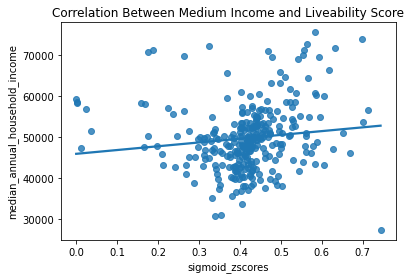

In [74]:
sql_query = pd.read_sql_query('SELECT * FROM for_correlation', conn)
df = pd.DataFrame(sql_query, columns = ['sigmoid_zscores', 'median_annual_household_income', 'avg_monthly_rent'])

income = sns.regplot(x='sigmoid_zscores',y='median_annual_household_income',data = df, ci=None, fit_reg=True) 
income.set_title("Correlation Between Medium Income and Liveability Score")

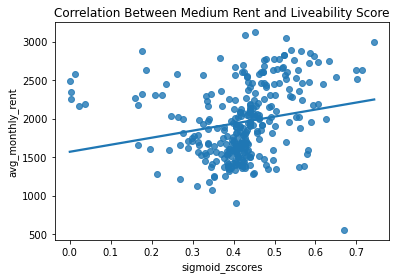

In [75]:
rent = sns.regplot(x = 'sigmoid_zscores', y = 'avg_monthly_rent',data = df, ci=None, fit_reg=True)
rent.set_title("Correlation Between Medium Rent and Liveability Score");

# Visualise the score Data

In [55]:
%matplotlib inline

## Read data from sql table
read_data = 
pd.read_sql_query('''SELECT  sigmoid_zscores, ST_AsText(final_score.geom) AS geom 
                     FROM final_score''', conn)

## Create the dataframe
map_dataframe = pd.DataFrame({
     'sigmoid_zscores': read_data['sigmoid_zscores'],
     'geom': read_data['geom']})


# background
map_dataframe = map_dataframe[map_dataframe['geom'].isnull()==False]
map_dataframe['geom'] = map_dataframe['geom'].apply(wkt.loads)

## Create the Geo dataframe
map_visual = gpd.GeoDataFrame(map_dataframe, geometry='geom')



<AxesSubplot:>

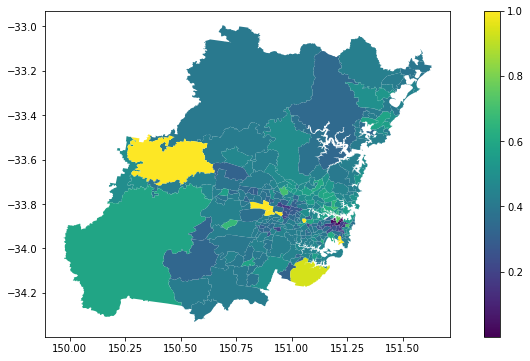

In [56]:
## Draw the graph by the score data

fig, ax = plt.subplots(1, figsize=(12,6))
map_visual.plot(ax=ax, column='sigmoid_zscores', legend=True)

<AxesSubplot:>

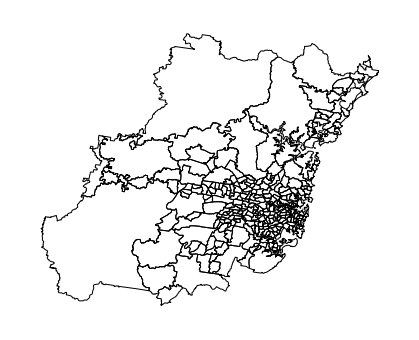

In [58]:
## To see the actural dataframe of geometry
gplt.polyplot(map_visual)

# Task 3

In [ ]:
####### Street_and_park_trees Dataset ###########

In [10]:
tree = gpd.read_file("Street_and_park_trees.csv")

In [11]:
# convert log and lat to Geometry data 
tree['geom'] = gpd.points_from_xy(tree.Longitude, tree.Latitude)
tree = tree.drop(columns=['Longitude', 'Latitude'])
tree.head()

,OID_,asset_id,TreeType,SpeciesName,CommonName,TreeHeight,TreeCanopyEW,TreeCanopyNS,Tree_Status,ObjectId,geometry,geom
0,201,TP10750,Park Tree,Eucalyptus pilularis,Blackbutt,11,7,7,Tree,1,None,POINT (151.17818 -33.88315)
1,1,TP00007,Park Tree,Caesalpinia ferrea,Leopard Tree,6,3,2,Tree,2,None,POINT (151.18201 -33.89560)
2,101,TS39775,Park Tree,Melaleuca styphelioides,Prickly Paperbark,6,3,4,Tree,3,None,POINT (151.17622 -33.88287)
3,202,TP10751,Park Tree,Eucalyptus microcorys,Tallow Wood,9,2,2,Tree,4,None,POINT (151.17816 -33.88323)
4,2,TP00010,Park Tree,Michelia champaca,Champak,10,2,2,Tree,5,None,POINT (151.18202 -33.89568)


In [12]:
del tree['geometry']
tree.columns= tree.columns.str.lower()
tree.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 47167 entries, 0 to 47166
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   oid_          47167 non-null  object  
 1   asset_id      47167 non-null  object  
 2   treetype      47167 non-null  object  
 3   speciesname   47167 non-null  object  
 4   commonname    47167 non-null  object  
 5   treeheight    47167 non-null  object  
 6   treecanopyew  47167 non-null  object  
 7   treecanopyns  47167 non-null  object  
 8   tree_status   47167 non-null  object  
 9   objectid      47167 non-null  object  
 10  geom          47167 non-null  geometry
dtypes: geometry(1), object(10)
memory usage: 4.0+ MB


In [13]:
q = """
DROP TABLE IF EXISTS table_tree;
CREATE TABLE table_tree (
    oid_ INTEGER, 
    asset_id TEXT, 
    treetype TEXT,
    speciesname  TEXT,
     commonname  TEXT,
      treeheight   FLOAT,
     treecanopyew FLOAT,
     treecanopyns FLOAT,
     tree_status TEXT,
     objectid  INTEGER,
    geom GEOMETRY(POINT,4283)
);"""

query(conn, q)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [ ]:
srid = 4283
tree['geom'] = tree['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))
tree

In [16]:
tree.to_sql('table_tree', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', 4283)})
query(conn, "select * from table_tree")

,oid_,asset_id,treetype,speciesname,commonname,treeheight,treecanopyew,treecanopyns,tree_status,objectid,geom
0,201,TP10750,Park Tree,Eucalyptus pilularis,Blackbutt,11.0,7.0,7.0,Tree,1,0101000020BB1000007D385AA7B3E562407A8C29010BF1...
1,1,TP00007,Park Tree,Caesalpinia ferrea,Leopard Tree,6.0,3.0,2.0,Tree,2,0101000020BB10000053395804D3E56240A54C40F8A2F2...
2,101,TS39775,Park Tree,Melaleuca styphelioides,Prickly Paperbark,6.0,3.0,4.0,Tree,3,0101000020BB100000EAD270A2A3E562402F0234EE01F1...
3,202,TP10751,Park Tree,Eucalyptus microcorys,Tallow Wood,9.0,2.0,2.0,Tree,4,0101000020BB1000006395B072B3E56240E697B8B60DF1...
4,2,TP00010,Park Tree,Michelia champaca,Champak,10.0,2.0,2.0,Tree,5,0101000020BB100000B942DF14D3E562406E3CD1A8A5F2...
...,...,...,...,...,...,...,...,...,...,...,...
47162,47061,TP14122,Park Tree,Eucalyptus botryoides,Swamp Mahogany,18.0,8.0,8.0,Tree,47163,0101000020BB10000031375913E2E56240A412BCBB99EF...
47163,47062,TP14124,Park Tree,Eucalyptus botryoides,Swamp Mahogany,18.0,5.0,5.0,Tree,47164,0101000020BB100000A51230FCE1E562404B5C9EEC98EF...
47164,47063,TP12925,Park Tree,Platanus acerifolia,London Plane,11.0,7.0,5.0,Tree,47165,0101000020BB100000911E1FE182E66240C5410E79EBEF...
47165,47064,TP05540,Park Tree,Archontophoenix alexandrae,Alexandra Palm,10.0,3.0,3.0,Tree,47166,0101000020BB1000009E3409FF4AE76240A96B3A93EAEF...


In [18]:
#sa3 inner city join sa2, neighbor
q = """
create view sa_threee as
select cast(population as float) as population, geom, sa3_name16
from table_neighbour join table_sa2 using(geom)
where SA3_NAME16 = 'Sydney Inner City'
"""
query(conn, q)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [19]:
# calculate number of trees per 1000 ppl in inner city area
q = """
create view for_tree_zscore as
select count(asset_id) / (population/1000) as num_tree_per_thousand_ppl, sa_threee.geom
FROM sa_threee JOIN table_tree ON ST_Contains(sa_threee.geom, table_tree.geom)
where treeheight > 0
group by sa_threee.geom, population/1000
"""
query(conn, q)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [20]:
#zscore tree
q = """
CREATE VIEW tree_zscore AS
WITH avg_sd AS (
    SELECT avg(num_tree_per_thousand_ppl) as avg_tree, stddev(num_tree_per_thousand_ppl) as sd_tree
    FROM for_tree_zscore
)

SELECT (num_tree_per_thousand_ppl - avg_tree) / sd_tree AS zscore_tree, geom
FROM for_tree_zscore, avg_sd
"""
query(conn, q)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [21]:
q = """SELECT * From tree_zscore;"""

query(conn, q)

,zscore_tree,geom
0,0.287300,0106000020BB10000001000000010300000001000000F7...
1,2.492146,0106000020BB100000010000000103000000010000000A...
2,0.710111,0106000020BB1000000100000001030000000100000008...
3,-0.874602,0106000020BB1000000100000001030000000100000014...
4,-0.312552,0106000020BB100000010000000103000000010000003F...
5,-0.093963,0106000020BB10000001000000010300000001000000A2...
6,-0.265904,0106000020BB10000001000000010300000001000000A8...
7,-0.635115,0106000020BB10000001000000010300000001000000B1...
8,-0.620469,0106000020BB1000000100000001030000000100000027...
9,-0.686952,0106000020BB100000030000000103000000010000000E...


In [ ]:
####### Drinking_fountains(water bubblers) Dataset ###########

In [22]:
drink = gpd.read_file('Drinking_fountains_(water_bubblers).geojson')

In [ ]:
del drink['Accessible'] ## Not Useful
drink.info()

In [24]:
drink.columns= drink.columns.str.lower()
drink.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   objectid   215 non-null    int64   
 1   site_name  215 non-null    object  
 2   suburb     215 non-null    object  
 3   location   215 non-null    object  
 4   geometry   215 non-null    geometry
dtypes: geometry(1), int64(1), object(3)
memory usage: 8.5+ KB


In [25]:
srid = 4283
drink['geom'] = drink['geometry'].apply(lambda x: WKTElement(x.wkt, srid=srid))
del drink["geometry"]

In [31]:
q = """
DROP TABLE IF EXISTS table_drink;
CREATE TABLE table_drink (
    objectid INTEGER, 
    site_name    TEXT, 
    suburb       TEXT,
    location      TEXT,
    geom GEOMETRY(POINT,4283)
);"""

query(conn, q)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [33]:
drink.to_sql('table_drink', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', 4283)})
query(conn, "select * from table_drink")

,objectid,site_name,suburb,location,geom
0,1,WJ Thurbon Playground,Newtown,Park,0101000020BB100000DEDC515DD2E5624023795789A6F2...
1,2,M J (Paddy) Dougherty Reserve,Glebe,Reserve,0101000020BB1000008124052728E66240BCBB06ED8DF0...
2,3,St James Park,Glebe,Park,0101000020BB10000048449A28E9E562408E44ADE1A2F0...
3,4,St James Park,Glebe,Park,0101000020BB100000AAEF8017E6E562407686D5B2ADF0...
4,5,John St Reserve,Glebe,Park,0101000020BB100000249A2543E4E562401C91D929B3F0...
...,...,...,...,...,...
210,211,Dr H J Foley Rest Park,Glebe,Park,0101000020BB1000005B32764FF6E56240FE8E7C29ADF0...
211,212,Thomas Portley Reserve,Glebe,Reserve,0101000020BB100000F79E6E4515E662404BDDA6843BF0...
212,213,Mary Ann Street Park,Ultimo,Park,0101000020BB1000000AF91CF35BE662404AA13C93BBF0...
213,214,Millard Reserve,Glebe,Park,0101000020BB10000019340F9326E66240A3E5E2446AF0...


In [34]:
# calculate number of trees per 1000 ppl in inner city area
q = """
create view for_water_zscore as
select count(objectid) / (population/1000) as num_waterbub_per_thousand_ppl, sa_threee.geom
FROM sa_threee JOIN table_tree ON ST_Contains(sa_threee.geom, table_tree.geom)
group by sa_threee.geom, population/1000
"""
query(conn, q)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [35]:
#zscore water bubble
q = """
CREATE VIEW water_zscore AS
WITH avg_sd AS (
    SELECT avg(num_waterbub_per_thousand_ppl) as avg_water, stddev(num_waterbub_per_thousand_ppl) as sd_water
    FROM for_water_zscore
)

SELECT (num_waterbub_per_thousand_ppl - avg_water) / sd_water AS zscore_water, geom
FROM for_water_zscore, avg_sd
"""
query(conn, q)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [ ]:
######## Final Process #######

In [37]:
#join water, tree zscore together
q = """
create view water_tree_zscores as
select *
from water_zscore join tree_zscore using(geom)
"""
query(conn, q)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [41]:
## used in graph

q = """
Create View live_sa3_task3 AS
select area_id, sigmoid_zscores, sa_threee.geom, sa3_name16
from final_score JOIN sa_threee ON ST_Contains(sa_threee.geom, final_score.geom)
"""
query(conn, q)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [42]:
q = """SELECT * From live_sa3_task3;"""

query(conn, q)

,area_id,sigmoid_zscores,geom,sa3_name16
0,117031329,0.000116,0106000020BB10000001000000010300000001000000A8...,Sydney Inner City
1,117031330,0.262967,0106000020BB100000010000000103000000010000000A...,Sydney Inner City
2,117031331,0.023327,0106000020BB1000000100000001030000000100000008...,Sydney Inner City
3,117031332,0.158317,0106000020BB1000000100000001030000000100000014...,Sydney Inner City
4,117031333,0.002530,0106000020BB10000001000000010300000001000000B1...,Sydney Inner City
5,117031334,0.013034,0106000020BB1000000100000001030000000100000027...,Sydney Inner City
6,117031335,0.037265,0106000020BB100000010000000103000000010000003F...,Sydney Inner City
7,117031336,0.002083,0106000020BB10000001000000010300000001000000A2...,Sydney Inner City
8,117031337,0.743469,0106000020BB100000030000000103000000010000000E...,Sydney Inner City
9,117031338,0.224480,0106000020BB10000001000000010300000001000000F7...,Sydney Inner City


In [ ]:
###### Graph by task 2 calculate formula of score ########

In [43]:
%matplotlib inline

## Read data from sql table
read_data = 
pd.read_sql_query('''SELECT  sigmoid_zscores, ST_AsText(final_score.geom) AS geom 
                     FROM live_sa3_task3''', conn)

## Create the dataframe
map_dataframe = pd.DataFrame({
     'sigmoid_zscores': read_data['sigmoid_zscores'],
     'geom': read_data['geom']})


# background
map_dataframe = map_dataframe[map_dataframe['geom'].isnull()==False]
map_dataframe['geom'] = map_dataframe['geom'].apply(wkt.loads)

## Create the Geo dataframe
map_visual = gpd.GeoDataFrame(map_dataframe, geometry='geom')



<AxesSubplot:>

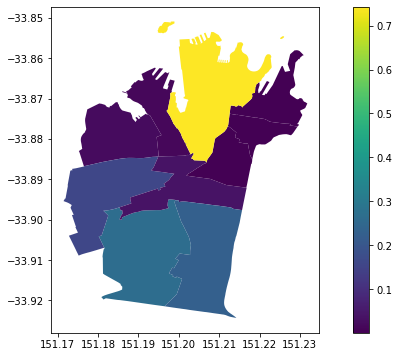

In [44]:
fig, ax = plt.subplots(1, figsize=(12,6))
map_visual.plot(ax=ax, column='sigmoid_zscores', legend=True)

In [ ]:
###### Graph by task 3 calculate formula of score ########

In [48]:
#join all zscores   ---> sa3 version with tree, water
q = """
Drop View live_sa3_task3_all;
Create view live_sa3_task3_all AS

WITH zscores_all AS (
    SELECT c.area_id, c.geom, zscore_crime, zscore_school, zscore_health,zscore_retail, zscore_accomodation, zscore_water, zscore_tree
    FROM new_crime_zscores c JOIN new_zscore_school USING (area_id) 
            JOIN new_health_zscores USING (area_id)
            JOIN new_retail_zscores USING (area_id)
            JOIN new_accommodation_zscores USING (area_id)
            join water_tree_zscores wt ON ST_Contains(wt.geom, c.geom)
)

SELECT area_id, geom,
    1/(1+(EXP(-(zscore_retail + zscore_health + zscore_accomodation - zscore_crime  + zscore_water + zscore_tree)))) AS sigmoid_zscores
FROM zscores_all
"""
query(conn, q)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [49]:
%matplotlib inline

## Read data from sql table
read_data = 
pd.read_sql_query('''SELECT  sigmoid_zscores, ST_AsText(final_score.geom) AS geom 
                     FROM live_sa3_task3_all''', conn)

## Create the dataframe
map_dataframe = pd.DataFrame({
     'sigmoid_zscores': read_data['sigmoid_zscores'],
     'geom': read_data['geom']})


# background
map_dataframe = map_dataframe[map_dataframe['geom'].isnull()==False]
map_dataframe['geom'] = map_dataframe['geom'].apply(wkt.loads)

## Create the Geo dataframe
map_visual = gpd.GeoDataFrame(map_dataframe, geometry='geom')



<AxesSubplot:>

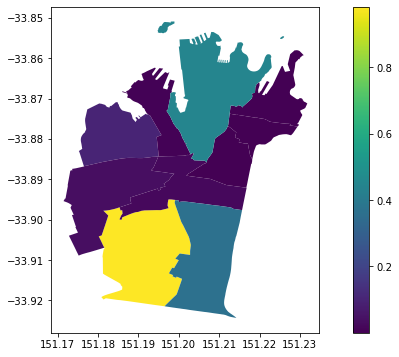

In [50]:
fig, ax = plt.subplots(1, figsize=(12,6))
# gplt.polyplot(map_visual_ori)
map_visual.plot(ax=ax, column='sigmoid_zscores', legend=True)

## Disconnect Database

In [ ]:
conn.close()
db.dispose()

In [8]:
from IPython.display import HTML
HTML('''
    <style> body {font-family: "Roboto Condensed Light", "Roboto Condensed";} h2 {padding: 10px 12px; background-color: #E64626; position: static; color: #ffffff; font-size: 40px;} .text_cell_render p { font-size: 15px; } .text_cell_render h1 { font-size: 30px; } h1 {padding: 10px 12px; background-color: #E64626; color: #ffffff; font-size: 40px;} .text_cell_render h3 { padding: 10px 12px; background-color: #0148A4; position: static; color: #ffffff; font-size: 20px;} h4:before{ 
    content: "@"; font-family:"Wingdings"; font-style:regular; margin-right: 4px;} .text_cell_render h4 {padding: 8px; font-family: "Roboto Condensed Light"; position: static; font-style: italic; background-color: #FFB800; color: #ffffff; font-size: 18px; text-align: center; border-radius: 5px;}input[type=submit] {background-color: #E64626; border: solid; border-color: #734036; color: white; padding: 8px 16px; text-decoration: none; margin: 4px 2px; cursor: pointer; border-radius: 20px;}</style>
    <script> code_show=true; function code_toggle() {if (code_show){$('div.input').hide();} else {$('div.input').show();} code_show = !code_show} $( document ).ready(code_toggle);</script>
    <form action="javascript:code_toggle()"><input type="submit" value="Hide/show all code."></form>
''') 